# CA1 performs posterior inference over the stimulus values!

### Hypothesis: CA1 performs Bayesian inference on the stimulus to infer current place in position x morph space

Posterior probability of the current stimulus, $P(C|S) \propto P(S|C)P(C)$ (Bayes Rule)

where $P(S|C)$ is the likelihood of the stimulus given the context (could also be thought of a noisy estimate of the stimulus), and $P(C)$ is the prior over the contexts


all we're going to do is change the prior and see how the MAP estimate (estimate from the posterior distribution changes as we change the stimulus)

In [1]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d as spline
from astropy.convolution import convolve


from matplotlib import pyplot as plt

%matplotlib inline


In [2]:
# preliminaries
gaussian = lambda mu,sigma,x: np.exp(-(mu-x)**2/sigma**2)
def gaussian_dens(mu,sigma,x):
    v = gaussian(mu,sigma,x)
    return v/v.sum()

def mult_and_norm(dens1,dens2):
    post = dens1*dens2
    return post/post.sum()



-0.3 1.3


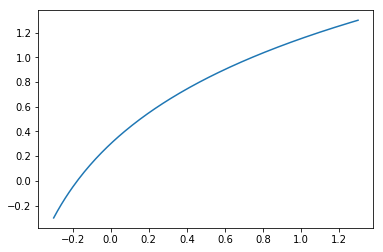

In [3]:

m = np.linspace(-.3,1.3,num=160)
f1,f2 = 3,8
mm = np.log(f1*(1-m) + f2*(m))
mm = (mm-np.amin(mm))/(np.amax(mm)-np.amin(mm)) *1.6 - .3
print(mm[0],mm[-1])
mm[0],mm[-1]=-.3,1.3
theta_corrected = np.copy(mm)
morph_2_logstim = spline(m,mm)
logstim_2_morph = spline(mm,m)


f,ax = plt.subplots()
ax.plot(m,mm)

theta = np.linspace(-.3,1.3,num=160)
log_theta = morph_2_logstim(theta)




In [4]:
# define function to run model
def run_posterior_inference(p_theta):
    # likelihood 
    p_s_theta = gaussian_dens(0,.2,theta)

    # posterior 
    p_theta_s = mult_and_norm(p_s_theta,p_theta)

    f_post_demo,ax_post_demo = plt.subplots(5,1,figsize=[3,15])
    ax_post_demo[0].plot(theta,p_theta,label='prior')
    ax_post_demo[0].plot(theta,p_s_theta,label='likelihood',alpha=.4)
    ax_post_demo[0].plot(theta,p_theta_s,label='posterior')
    ax_post_demo[0].legend()


    for i,s in enumerate([.25,.5,.75,1]):
        # likelihood 
        p_s_theta = gaussian_dens(s,.2,theta)

        # posterior 
        p_theta_s = mult_and_norm(p_s_theta,p_theta)


        ax_post_demo[i+1].plot(theta,p_theta,label='prior')
        ax_post_demo[i+1].plot(theta,p_s_theta,label='likelihood',alpha=.4)
        ax_post_demo[i+1].plot(theta,p_theta_s,label='posterior')
        
    f_post_dens,ax_post_dens = plt.subplots()
    theta_hat=[]
    for i,s in enumerate(theta):
        p_s_theta = gaussian(s,.2,theta)
        p_theta_s = p_s_theta*p_theta
        p_theta_s/=p_theta_s.sum()
        ax_post_dens.plot(logstim_2_morph(theta),p_theta_s,color=plt.cm.cool(1-i/100.))
        theta_hat.append(theta[np.argmax(p_theta_s)])

    ax_post_dens.set_ylabel('P')
    ax_post_dens.set_xlabel('morph value')
    ax_post_dens.set_title('Posterior density for different stimulus values')

    f_MAP,ax_MAP = plt.subplots()
    ax_MAP.scatter(logstim_2_morph(theta),logstim_2_morph(np.array(theta_hat)))
    ax_MAP.set_ylim([1.3,-.3])
    ax_MAP.set_ylabel('MAP morph estimate')
    ax_MAP.set_xlabel('true morph value')
    
    return (f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP)

## Rare Morph Simulation

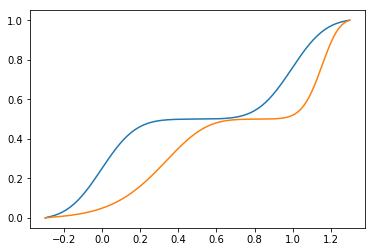

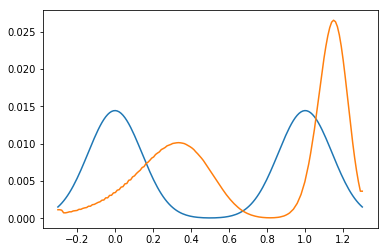

In [5]:
# setup prior in logspace

rare_prior = np.zeros([160,])
rare_prior = gaussian(0,.2,theta)+gaussian(1,.2,theta)
rare_prior /= rare_prior.sum()

cum_rare_prior = np.cumsum(rare_prior)
cum_rare_prior[0],cum_rare_prior[-1] = 0,1
cum_rare_spline = spline(theta,cum_rare_prior)
log_cum_rare_spline = spline(theta_corrected,cum_rare_prior)
log_cum_rare = log_cum_rare_spline(theta)
f,ax = plt.subplots()
ax.plot(theta,cum_rare_prior)
ax.plot(theta_corrected,cum_rare_prior)


f,ax = plt.subplots()
ax.plot(theta,rare_prior)

log_rare_dens = log_cum_rare[1:]-log_cum_rare[:-1]
log_rare_dens = np.append(log_rare_dens,log_rare_dens[-1])
log_rare_dens /=log_rare_dens.sum()

ax.plot(theta,log_rare_dens)


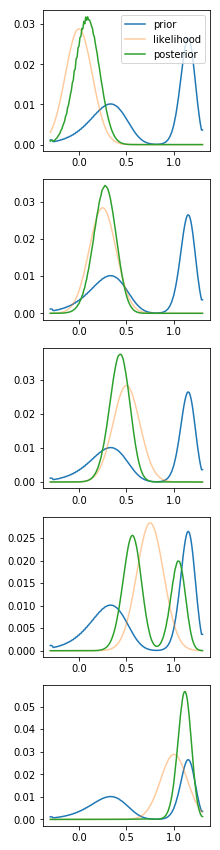

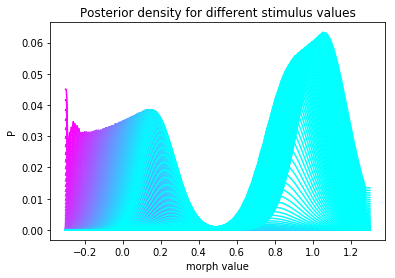

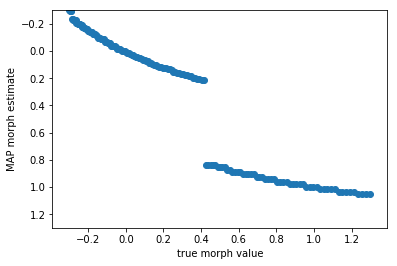

In [6]:
# rare morph case


(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(log_rare_dens)
    



## More realistic familiar morph prior 

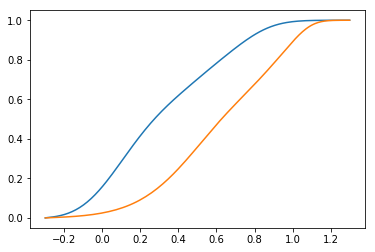

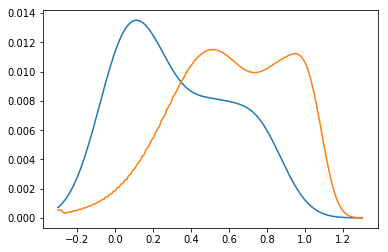

In [7]:
# setup prior in logspace

fam_prior = np.zeros([160,])
for morph in [0,.25,.5,.75,.1]:
    fam_prior+=gaussian(morph,.2,theta)
fam_prior /= fam_prior.sum()

cum_fam_prior = np.cumsum(fam_prior)
cum_fam_prior[0],cum_fam_prior[-1] = 0,1
cum_fam_spline = spline(theta,cum_fam_prior)
log_cum_fam_spline = spline(theta_corrected,cum_fam_prior)
log_cum_fam = log_cum_fam_spline(theta)
f,ax = plt.subplots()
ax.plot(theta,cum_fam_prior)
ax.plot(theta_corrected,cum_fam_prior)


f,ax = plt.subplots()
ax.plot(theta,fam_prior)

log_fam_dens = log_cum_fam[1:]-log_cum_fam[:-1]
log_fam_dens = np.append(log_fam_dens,log_fam_dens[-1])
log_fam_dens /=log_fam_dens.sum()

ax.plot(theta,log_fam_dens)


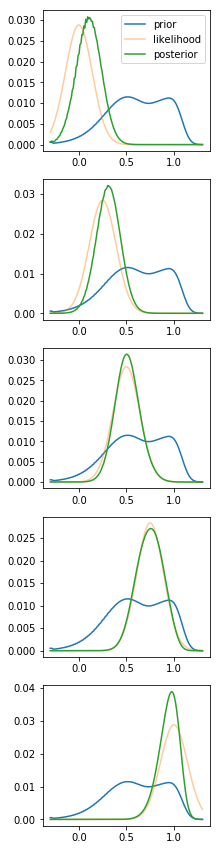

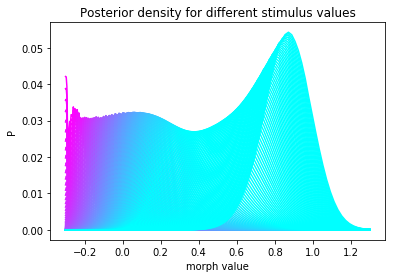

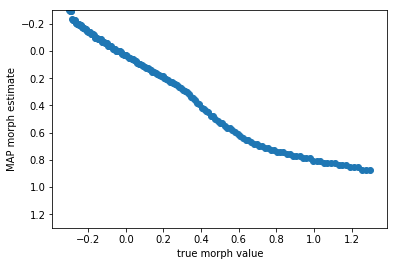

In [8]:


(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(log_fam_dens)
    
# f_post_demo.savefig('./fam_posterior_demo.png')
# f_post_dens.savefig('./fam_posteriors.png')
# f_MAP.savefig('./MAP_fam.png')


# Implementation in a K-WTA network

In [89]:
# design input cells - gaussian tuning for different stimulus values
nInputs = 1000
THETA = np.linspace(-.3,1.3,num=nInputs)

eta = .2 #15
tau = .001

sigma = .1

def network_model(log_cumprior_spline, n_neurons=100, wta_k = .4):
    

    W = np.random.rand(nInputs,n_neurons)
    k = int(n_neurons*wta_k)
    
    
    #working in log space
    samples = log_cumprior_spline(np.linspace(0,1,num=1000))
    eta_vec = eta*samples[::-1]
    samples = np.random.permutation(samples)
    for i,s in enumerate(samples.tolist()):
        prob_input =gaussian(THETA,sigma,s+.2*np.random.rand(1)) + .01*np.random.rand(THETA.shape[0])
        act = np.matmul(W.T,prob_input)
        Y = np.zeros(act.shape)
        sort = np.argsort(act)

        Y[sort[-1:-k-1:-1]]=1/nInputs*act[sort[-1:-k-1:-1]] #- act[sort[-k-1]].mean()
#         Y = np.maximum(act -1.*act.mean(),0)
        dw = eta*prob_input[:,np.newaxis]*(Y[np.newaxis,:]) #- tau*W
        W+=dw 
        #W/=.001*np.linalg.norm(W,1,axis=0)[np.newaxis,:]
        W=np.minimum(W,10)
        W = np.maximum(W,0)

    

    morph_theta = np.linspace(-.1,1.1,num=1000)
    test_theta = morph_2_logstim(morph_theta)
    YY = np.zeros([test_theta.shape[0],n_neurons])
    for i,s in enumerate(test_theta.tolist()):
        
        prob_input =gaussian(THETA,sigma,s+.2*np.random.rand(1)) + .01*np.random.rand(THETA.shape[0])

        act = np.matmul(W.T,prob_input)
        sort = np.argsort(act)
        
        YY[i,sort[-1:-k-1:-1]]=1/nInputs*act[sort[-1:-k-1:-1]] #-.1*act[sort[-k-1]].mean()
        #YY[i,:] = np.maximum(act -1.*act.mean(),0)

    centroid0, centroid1 = YY[morph_theta<.1,:].mean(axis=0),YY[morph_theta>.9,:].mean(axis=0)
    centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
    centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
    print(centroid0.shape,centroid1.shape,YY.shape)
    lar = np.log(np.matmul(YY,centroid0[:,np.newaxis])+ 1E-5)-np.log(np.matmul(YY,centroid1[:,np.newaxis])+ 1E-5)
    
    return W,YY,lar



(1000,) (1000,) (1000, 1000)
0.0 1.1334582256494314
(1000,) (1000,) (1000, 1000)
0.0 1.1329114294783689
(1000,) (1000,) (1000, 1000)
0.0 1.1355129668542634
(1000,) (1000,) (1000, 1000)
0.0 1.1339400449119934
(1000,) (1000,) (1000, 1000)
0.0 1.1319325965879106


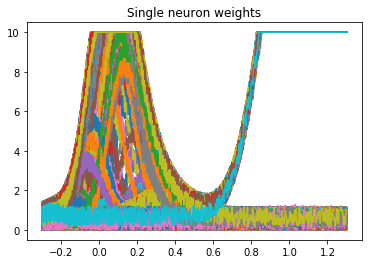

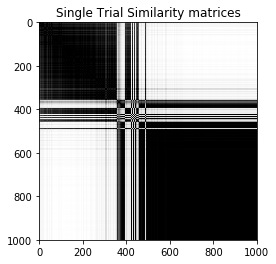

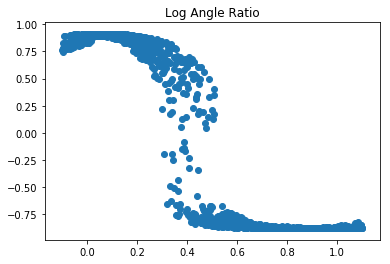

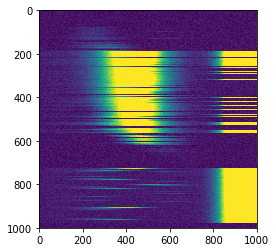

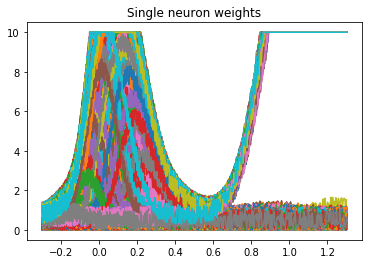

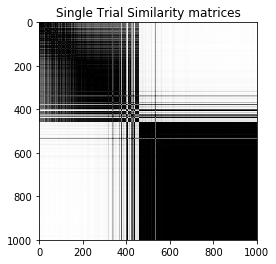

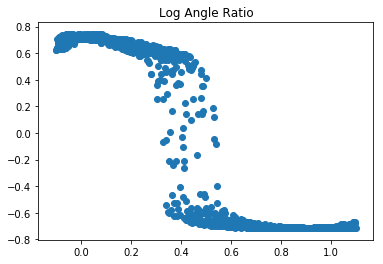

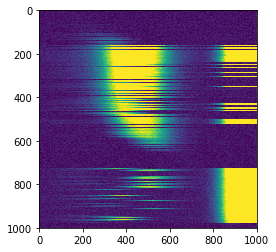

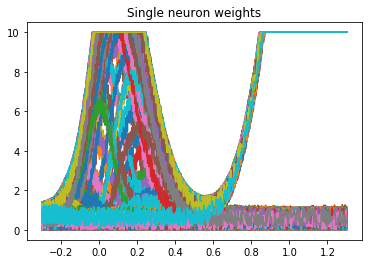

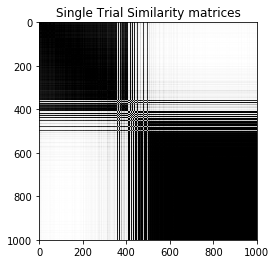

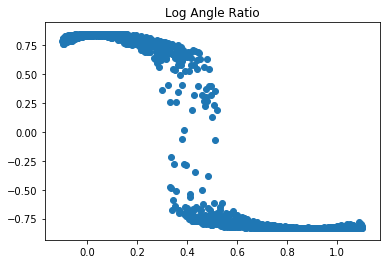

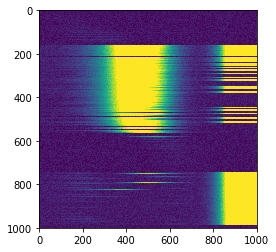

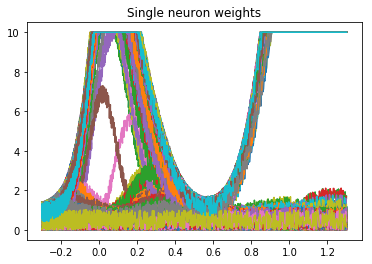

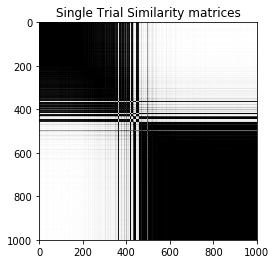

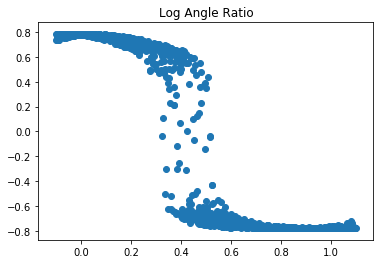

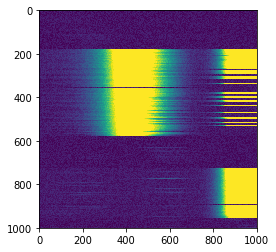

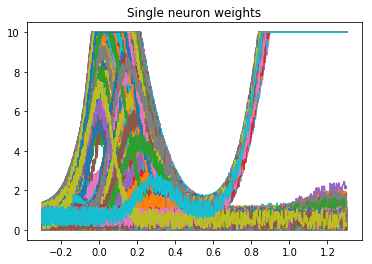

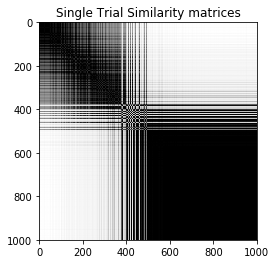

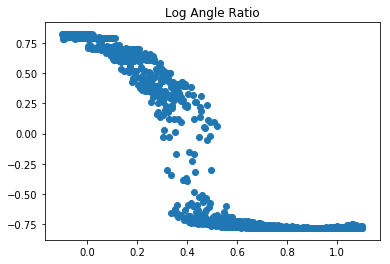

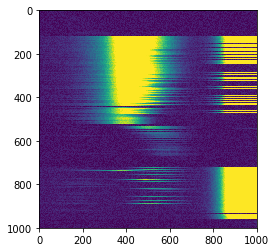

In [90]:
SS_rare,LAR_rare = [],[]
for i in range(5):
    W_rare,YY_rare,lar_rare= network_model(spline(cum_rare_prior,theta_corrected),wta_k=.4,n_neurons=1000)
    print(np.amin(YY_rare),np.amax(YY_rare))
    f,ax = plt.subplots()
    trsh=ax.plot(logstim_2_morph(THETA),W_rare)
    ax.set_title('Single neuron weights')

    YY_ = YY_rare/np.linalg.norm(YY_rare+1E-5,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)

    SS_rare.append(S)
    LAR_rare.append(lar_rare)

    f,ax = plt.subplots()
    ax.imshow(S,cmap='Greys')
    ax.set_title('Single Trial Similarity matrices')

    f,ax = plt.subplots()
    ax.scatter(np.linspace(-.1,1.1,num=1000),lar_rare)
    ax.set_title('Log Angle Ratio')

    f,ax = plt.subplots()
    # ax.imshow(W_rare.T)
    weight_sort = np.argsort(np.argmax(W_rare,axis=0))
    ax.imshow(W_rare[:,weight_sort].T) #,vmax=4)

In [ ]:
flat_prior_spline = spline(np.linspace(0,1,num=theta_corrected.shape[0]),theta_corrected)
SS_fam,LAR_fam=[],[]
# flat_prior_spline = spline(cum_fam_prior,theta_corrected)
for i in range(5):
    W_fam,YY_fam,lar_fam= network_model(flat_prior_spline,wta_k=.4,n_neurons=1000)
    print(np.amin(YY_fam),np.amax(YY_fam))
    f,ax = plt.subplots()
    trsh=ax.plot(logstim_2_morph(THETA),W_fam)
    ax.set_title('Single neuron weights')

    YY_ = YY_fam/np.linalg.norm(YY_fam+1E-5,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)
    print(np.amin(S),np.percentile(S,80))
    SS_fam.append(S)
    LAR_fam.append(lar_fam)
    f,ax = plt.subplots()
    ax.imshow(S,cmap='Greys')
    ax.set_title('Single Trial Similarity matrices')


    f,ax = plt.subplots()
    ax.scatter(np.linspace(-.1,1.1,num=1000),lar_fam)
    ax.set_title('Log Angle Ratio')
    
    f,ax = plt.subplots()
    weight_sort = np.argsort(np.argmax(W_fam,axis=0))
    ax.imshow(W_fam[:,weight_sort].T,vmax=4)

(1000,) (1000,) (1000, 1000)
0.0 1.1362988163510328
0.5088931434651286 0.9744451318940085


In [ ]:
SS_rare_mu = np.array(SS_rare).mean(axis=0)
SS_fam_mu = np.array(SS_fam).mean(axis=0)

In [ ]:
print(np.amin(SS_rare_mu),np.amin(SS_fam_mu))

In [ ]:
SS_dif = SS_rare_mu-SS_fam_mu

In [ ]:
f,ax = plt.subplots()
ax.imshow(SS_dif,vmin=-.2,vmax=.2,cmap='seismic')

In [ ]:
print(THETA[0],THETA[-1])
# bin_edges = np.linspace(-.3,1.3,num=6)
bin_edges = np.array([-.3,.125,.375,.625,.85,1.3])

SS_dif_mu = np.zeros([5,5])



for row in range(bin_edges.shape[0]-1):
    row_inds = (THETA>bin_edges[row]) & (THETA<=bin_edges[row+1])
    for col in range(bin_edges.shape[0]-1):
        col_inds = (THETA>bin_edges[col]) & (THETA<=bin_edges[col+1])
        vals = SS_dif[row_inds[:,np.newaxis]*col_inds[np.newaxis,:]]
        
        SS_dif_mu[row,col]=vals.mean()
print(bin_edges)

In [ ]:
f,ax = plt.subplots()
ax.imshow(SS_dif_mu,vmin=-.2,vmax=.2,cmap='coolwarm')

In [ ]:
bins = np.linspace(-1.5,1.5)
hist_rare,edges = np.histogram(np.array(LAR_rare).ravel(),bins=bins)
print(hist_rare.shape)
hist_rare =hist_rare/hist_rare.sum()
f,ax = plt.subplots()
ax.fill_between(bins[1:],hist_rare,color=plt.cm.copper(1.))


hist_fam,edges = np.histogram(np.array(LAR_fam).ravel(),bins=bins)
hist_fam = hist_fam/hist_fam.sum()
ax.fill_between(bins[1:],hist_fam,color=plt.cm.cividis(0.))